낙산 해수욕장

!!! 아래 셀의 경로를 수정하여 이 노트북이 있는 디렉토리로 바꿔주세요.

In [74]:
cd /tf/mnt/research_gis/coastline-erosion-predict/samples

/tf/mnt/research_gis/coastline-erosion-predict/samples


1. 함수들 불러오기

In [75]:
import sys
sys.path.insert(0, "../lib/")
from LineProcessor import *
from Utils import convert_axis

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely


2. Shapefile 불러오기

In [76]:
TARGET_DIR = './shapefile/'
K = int(1e0)    #좌표 변화율이 너무 낮은 단위일때 곱해줄 상수

LINE_DATAS = [f'{TARGET_DIR}/관리도/WGIS_COASTLINE.shp', f'{TARGET_DIR}/현황도/WGIS_COASTLINE.shp']

#처리 가능한 geometry type : LineString, MultiLineString
#폴리곤 데이터 불러오기 불가능

geos = []
for name in LINE_DATAS:
  data = gpd.read_file(name, encoding="euc-kr")
  idx = data[(data["SD"] == "강원도") & (data["SGG"] == "양양군")].index.tolist()
  for i in idx:
    target = data["geometry"][i]
    if isinstance(target, shapely.geometry.linestring.LineString):
      geos = geos + [np.array(target.coords) * K]      
    elif isinstance(target, shapely.geometry.multilinestring.MultiLineString):
      geoms_list = list(target.geoms)
      geos = geos + [np.array(geoms_list[j].coords) * K for j in range(len(geoms_list))]


3. 불러온 데이터 확인

x range : 1097134.9090287758 ~ 1115130.2890977315
y range : 1991657.0967773404 ~ 2018461.023316044


(1991657.0967773404, 2018461.023316044)

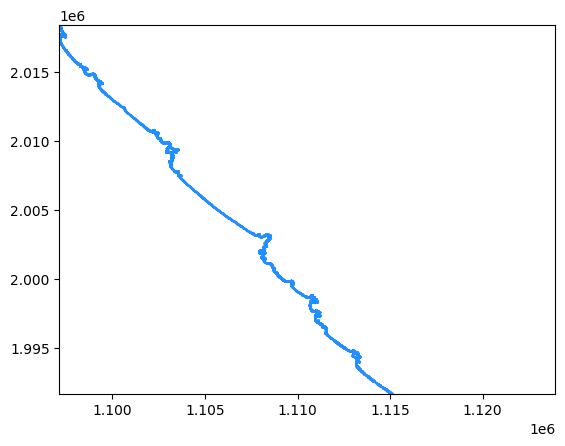

In [77]:
gca = plt.gca()
#원본 데이터가 '점'들의 좌표로 이루어 졌으므로, 보간해서 선처럼 보이게 함.
inters = interporation_points(geos, 10 * K)
#plot
gca.scatter(inters[:,0], inters[:,1], color='dodgerblue', s = 0.01)
origin_x_min = np.min(inters[:,0])
origin_x_max = np.max(inters[:,0])
origin_y_min = np.min(inters[:,1])
origin_y_max = np.max(inters[:,1])
print(f"x range : {origin_x_min} ~ {origin_x_max}")
print(f"y range : {origin_y_min} ~ {origin_y_max}")
gca.set_xlim([origin_x_min, origin_x_min + max([origin_x_max - origin_x_min, origin_y_max - origin_y_min])])
gca.set_ylim([origin_y_min, origin_y_min + max([origin_x_max - origin_x_min, origin_y_max - origin_y_min])])

4. 범위 자르기(또는 선 추가)

x range : 1099225.1527480737 ~ 1100504.2346303265
y range : 2012504.0661472955 ~ 2014199.6379662934


(2012504.0661472955, 2014199.6379662934)

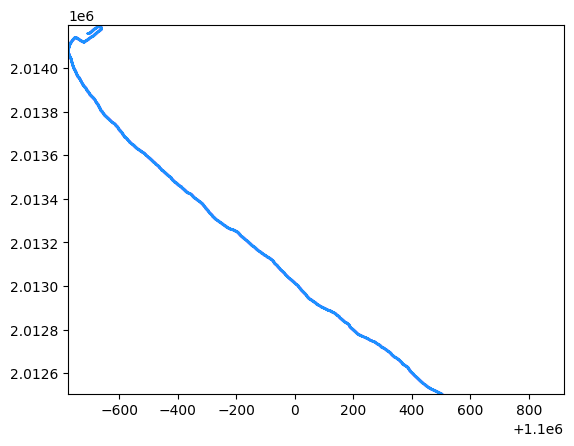

In [78]:
#자를 범위 지정
x_range = (1.0975 * 1e6 * K, 1.1025 * 1e6 * K)
y_range = (2.0125 * 1e6 * K, 2.0142 * 1e6 * K)
step = 0.1 * K

#자르고 보간해서 출력함.
cut_geo = cutting(geos, x_range, y_range)
inters = interporation_points(cut_geo, step)
gca = plt.gca()
gca.scatter(inters[:,0], inters[:,1], color='dodgerblue', s = 0.01)
#min/max 좌표 찾아둠
cut_x_min = np.min(inters[:,0])
cut_x_max = np.max(inters[:,0])
cut_y_min = np.min(inters[:,1])
cut_y_max = np.max(inters[:,1])


#선 직접 추가하기
#add_line의 원소로 np.array([(point1.x , point1.y), (point2.x, point2.y)])
#추가하면 point1 부터 point2 까지 선이 추가로 그려짐(빨간색으로 표시됨)
#
add_line = []
if len(add_line) > 0:
    add_line_inter = interporation_points(add_line, step)
    gca.scatter(add_line_inter[:,0], add_line_inter[:,1], color='red', s = 0.01)
    cut_geo += add_line
    #추가된 선들의 min/max 좌표 찾기
    add_line_x_min = np.min(add_line_inter[:,0])
    add_line_x_max = np.max(add_line_inter[:,0])
    add_line_y_min = np.min(add_line_inter[:,1])
    add_line_y_max = np.max(add_line_inter[:,1])
    #추가된 선들과 기존 선들의 min/max 찾기
    cut_x_min = np.min([cut_x_min, add_line_x_min])
    cut_x_max = np.max([cut_x_max, add_line_x_max])
    cut_y_min = np.min([cut_y_min, add_line_y_min])
    cut_y_max = np.max([cut_y_max, add_line_y_max])

#출력 범위 설정
print(f"x range : {cut_x_min} ~ {cut_x_max}")
print(f"y range : {cut_y_min} ~ {cut_y_max}")

gca.set_xlim([cut_x_min, cut_x_min + max([cut_x_max - cut_x_min, cut_y_max - cut_y_min])])
gca.set_ylim([cut_y_min, cut_y_min + max([cut_x_max - cut_x_min, cut_y_max - cut_y_min])])

5. 지도 행렬로 변환하기

concat_line : input line 5개
to_grid() : a.shape : (48870, 2) / x_range : (1099225, 1100505) / y_range : (2012504, 2014200)
to_grid() : matrix shape : (1280, 1696)
영역 갯수 : 3


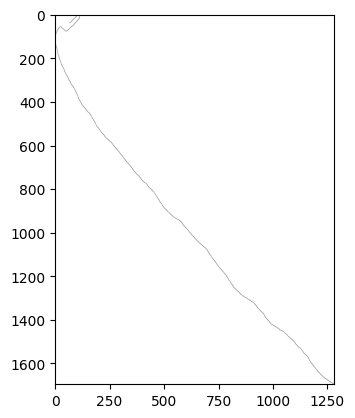

In [79]:
# shapefile의 line들을 병합해야 하는데, 병합이 가능한 최대 거리
max_diff = 30 * K

#선 병합
concat_geos = concat_line(cut_geo, max_diff)

#보간
interp_geos = interporation_points(concat_geos, step)

#행렬화
matrix, xr, yr = to_grid(interp_geos)

#행렬의 x,y축 기준을 matrix_initializer에서 요구하는 것에 맞게 치환함.
#아래는 covert_axis 함수의 설명
"""
(x,y), x축이 커지는 방향 : 오른쪽 / y축이 커지는 방향 : 위쪽
인 행렬을
(y,x), x축이 커지는 방향 : 오른쪽 / y축이 커지는 방향 : 아래쪽(일반적인 2차원 행렬/이미지 형태)
로 바꿈
"""
#
matrix = convert_axis(matrix)

#선 기반으로 영역 구분
painted_mat, colors = painting(matrix)
print(f"영역 갯수 : {colors}")

plt.imshow(img_matrix_lines(painted_mat))

6. 행렬 영역에 값 지정해주기, 확장...

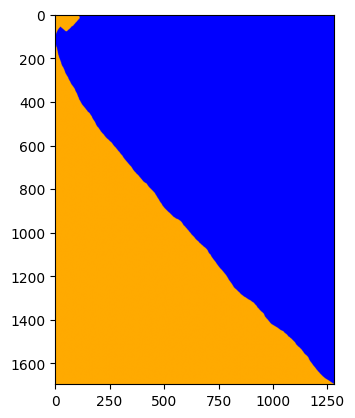

In [80]:
#결과 행렬 생성(기본값 : )
x = np.zeros_like(painted_mat)

#바다영역 추출 및 적용
sea_val = painted_mat[0,-1]
x[painted_mat == sea_val] = 1

plt.imshow(img_matrix_areas(x))



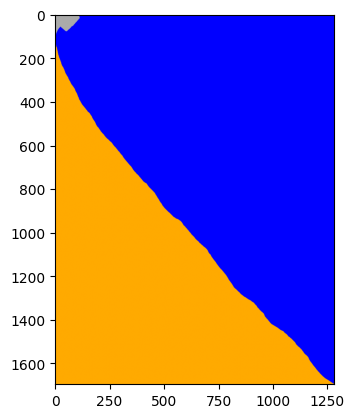

In [81]:
#좌상단 벽지역 추출
rock_val = painted_mat[0,0]
#좌상단 지역에 해당하는 영역(해안선포함)을 모두 벽으로 지정
rock_area = x[:np.max(np.where(painted_mat==rock_val)[1]), :]
rock_area[rock_area == 0] = 2

plt.imshow(img_matrix_areas(x))



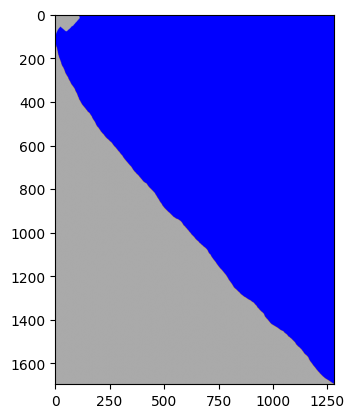

In [82]:
#좌하단 영역 추출해서 벽으로 지정
rock2_val = painted_mat[-1,0]
x[painted_mat == rock2_val] = 2

plt.imshow(img_matrix_areas(x))


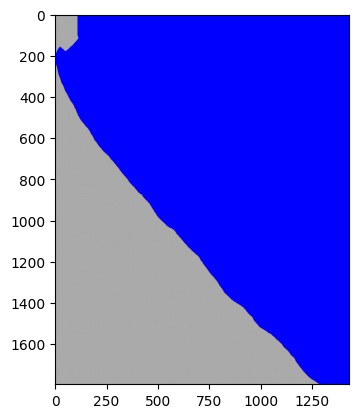

In [83]:
#바다영역 확장
#동쪽으로 150칸 증가, 바다영역(값 1)으로 채움
x = expand_mat(x, 3, 150, 1)
#북쪽으로 100칸 증가, 기존 값과 동일하게 채움
x = expand_mat(x, 0, 100)

plt.imshow(img_matrix_areas(x))

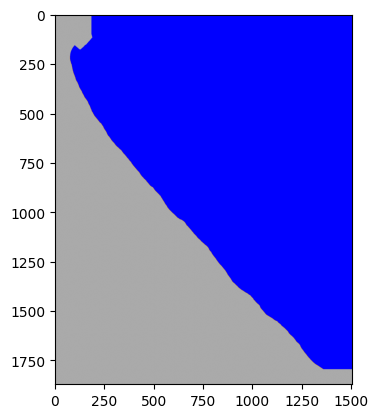

In [84]:

#좌하단으로 확장
#남쪽으로 75칸 증가, 벽 영역(값 2)으로 채움
x = expand_mat(x, 2, 75, 2)
#서쪽으로 75칸 증가, 벽 영역(값 2)으로 채움
x = expand_mat(x, 1, 75, 2)


plt.imshow(img_matrix_areas(x))

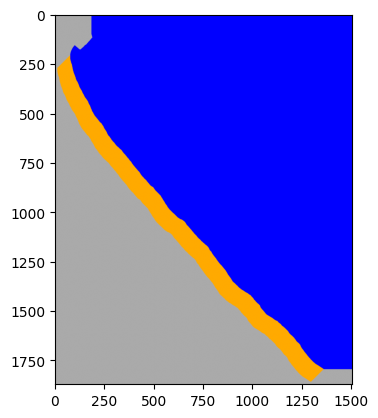

In [85]:

#해안선 위치를 구해서, 좌하단으로 63칸 전진시키면서 주변 3x3셀을 지상 영역으로 칠함.
coastline_mask = (x==0)
coastline_points = np.where(coastline_mask)
coastline_count = len(coastline_points[0])
for i in range(coastline_count):
  coast_len = 63
  paintlen = 1
  r = coastline_points[0][i]
  c = coastline_points[1][i]
  for j in range(coast_len):
    add_r = j
    add_c = -j
    if r + add_r < 0 or c + add_c < 0 or r + add_r >= x.shape[0] or c + add_c >= x.shape[1]:
      break
    x[max([r+add_r-paintlen, 0]):r+add_r+paintlen+1,
      max([c+add_c-paintlen, 0]):c+add_c+paintlen+1] = 0

plt.imshow(img_matrix_areas(x))

7. 처리 완료된 행렬 저장하기

In [86]:
save_path = "./matrix_file/naksan1.npy"
np.save(save_path, x)
print(f"행렬 처리 결과가 {save_path}에 저장되었습니다.")

행렬 처리 결과가 ./matrix_file/naksan1.npy에 저장되었습니다.
